The code in this notebook has been produced by following the tutorial in the [LangGraph's Quick Start Tutorial](https://langchain-ai.github.io/langgraph/tutorials/introduction/) 

## 0 - Setup

In [1]:
import os
import json

from dotenv import load_dotenv

from typing import Annotated, Literal

from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI

from langchain_core.messages import ToolMessage, BaseMessage, AIMessage
from langchain_core.pydantic_v1 import BaseModel

from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

In [2]:
load_dotenv()

True

In [4]:
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

## 1 - Build a Basic Chatbot

In [4]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [5]:
graph_builder = StateGraph(State)

In [6]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [7]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [8]:
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [9]:
graph_builder.add_edge(START, "chatbot")

In [10]:
graph_builder.add_edge("chatbot", END)

In [11]:
graph = graph_builder.compile()

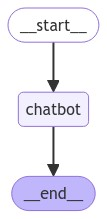

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [21]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User:  Hi, my name is Jose


Assistant: Hi Jose! How can I assist you today?


User:  I don't know maths. Can you solve the following operation on my behalf? 2 + 2


Assistant: Sure! The result of the operation \(2 + 2\) is \(4\).


User:  quit


Goodbye!


## 2 - Enhancing Chatbot with Tools

In [31]:
search = TavilySearchResults(max_results=2)

In [32]:
tools = [search]

In [33]:
search.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:'},
 {'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': 'Each node in a LangGraph graph has the ability to access, read, and write to the state. When a node modifies the state, it effectively broadcasts this information to all other nodes within the ...'}]

In [44]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOpenAI(model="gpt-4o-mini")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [45]:
class BasicToolNode:
    """ A Node that runs the tools requested in the last AIMessage. """

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [46]:
tool_node = BasicToolNode(tools=tools)

In [47]:
graph_builder.add_node("tools", tool_node)

In [48]:
def route_tools(state: State) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

In [49]:
# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)

In [50]:
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

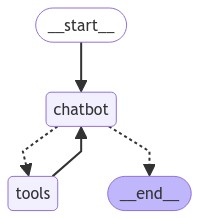

In [51]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [52]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

User:  Hola, me llamo Jose


Assistant: ¡Hola, Jose! ¿En qué puedo ayudarte hoy?


User:  Quién ganó la Euro2024?


Assistant: 
Assistant: [{"url": "https://es.wikipedia.org/wiki/Espa\u00f1a_en_la_Eurocopa_2024", "content": "La selecci\u00f3n de f\u00fatbol de Espa\u00f1a fue la ganadora de la Eurocopa 2024, torneo que se disput\u00f3 en Alemania entre el 14 de junio y el 14 de julio de 2024. 1 En la final derrotaron a Inglaterra por 2-1 con goles de Nico Williams y Mikel Oiarzabal. Signific\u00f3 el cuarto t\u00edtulo continental convirti\u00e9ndose en la selecci\u00f3n m\u00e1s laureada. 2 ."}, {"url": "https://cnnespanol.cnn.com/2024/07/14/espana-inglaterra-en-vivo-final-eurocopa-2024-resultado-goles-orix/", "content": "La Roja se impone 2-1 a Inglaterra y se convierte en el m\u00e1ximo ganador en la historia de la Euro. Espa\u00f1a derrota a Inglaterra por 2-1 en la final de la UEFA Euro 2024 y se proclama campeona de ..."}]
Assistant: La selección de fútbol de España ganó la Eurocopa 2024, que se disputó en Alemania. En la final, España derrotó a Inglaterra por 2-1, con goles de Nico Williams y

User:  Y quién es el actual campeón de Wimbledon?


Assistant: 
Assistant: [{"url": "https://www.sportingnews.com/mx/tenis/news/partidos-hoy-wimbledon-2023-horarios-resultados/suurduvn4rm24ebuttugqqyw", "content": "Wimbledon 2023 vio un campe\u00f3n nunca antes visto. Toda la fiesta estaba preparada para Novak Djokovic , que iba camino a su octava conquista, quinta de manera consecutiva. Pero Carlos Alcaraz le ..."}, {"url": "https://www.abc.es/deportes/tenis/alcaraz-djokovic-directo-final-wimbledon-directo-hoy-20230716191513-di.html", "content": "Carlos Alcaraz es el ganador de Wimbledon 2023. El tenista murciano ha ganado por 3-2 a Novak Djokovic (1-6, 7-6, 6-1, 3-6 y 6-4). Sigue en directo todas las reacciones y felicitaciones tras su ..."}]
Assistant: El actual campeón de Wimbledon es Carlos Alcaraz, quien ganó el torneo en 2023 al vencer a Novak Djokovic con un marcador de 3-2 (1-6, 7-6, 6-1, 3-6 y 6-4).


User:  quit


Goodbye!


## 3 - Adding Memory to the Chatbot

In [54]:
memory = MemorySaver()

In [62]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [65]:
graph = graph_builder.compile(checkpointer=memory)

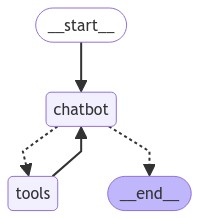

In [66]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [67]:
config = {"configurable": {"thread_id": "1"}}

In [68]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello, Will! How can I assist you today?


In [69]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name, Will! How can I help you today?


In [70]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', id='7f038c66-4c19-4220-bf89-76d98914f958'), AIMessage(content='Hello, Will! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 87, 'total_tokens': 99}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_9722793223', 'finish_reason': 'stop', 'logprobs': None}, id='run-0653992c-3dff-4750-b153-49ca06dfc390-0', usage_metadata={'input_tokens': 87, 'output_tokens': 12, 'total_tokens': 99}), HumanMessage(content='Remember my name?', id='752eb7d5-5fee-4053-8147-6651c0ed1cb1'), AIMessage(content='Yes, I remember your name, Will! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 110, 'total_tokens': 127}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_9722793223', 'finish_reason': 'stop', 'logpro

## 4 - Human-in-the-loop

In [72]:
memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [73]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

In [74]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_VfPZbDoWUCNGKkmT6a4AFhF1)
 Call ID: call_VfPZbDoWUCNGKkmT6a4AFhF1
  Args:
    query: LangGraph


In [75]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [76]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': 'call_VfPZbDoWUCNGKkmT6a4AFhF1',
  'type': 'tool_call'}]

In [77]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.langchain.com/langgraph", "content": "LangGraph is a framework for building stateful, multi-actor agents with LLMs that can handle complex scenarios and collaborate with humans. Learn how to use LangGraph with Python or JavaScript, and deploy your agents at scale with LangGraph Cloud."}, {"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large language model (LLM) applications. Learn how to use LangGraph to create stateful, flexible, and scalable systems with nodes, edges, and state management."}]
================================== Ai Message ==================================

Here are some key insights about LangGraph based on recent research:

1. **Overview**: LangGraph is a framework designed for building stateful,

## 5 - Manually updating the State

In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)

user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [80]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_CQpsYZvudWGRAtcBrJYe4dJK)
 Call ID: call_CQpsYZvudWGRAtcBrJYe4dJK
  Args:
    query: LangGraph


In [82]:
answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)

In [83]:
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]

In [84]:
new_messages[-1].pretty_print()

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


In [86]:
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef66c69-a016-621d-8002-84a521ba6865'}}

In [90]:
print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"])



Last 2 messages;
[HumanMessage(content="I'm learning LangGraph. Could you do some research on it for me?", id='81595355-be1b-47d3-83c4-29e8d1c11c1a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_CQpsYZvudWGRAtcBrJYe4dJK', 'function': {'arguments': '{"query":"LangGraph"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 94, 'total_tokens': 113}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f33667828e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-402e8e72-a06e-4b67-8c25-7a7c19f964f2-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'call_CQpsYZvudWGRAtcBrJYe4dJK', 'type': 'tool_call'}], usage_metadata={'input_tokens': 94, 'output_tokens': 19, 'total_tokens': 113}), ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='996976

In [96]:
for msg in graph.get_state(config).values["messages"]:
    print(f"- {type(msg)}: {msg.content}")

- <class 'langchain_core.messages.human.HumanMessage'>: I'm learning LangGraph. Could you do some research on it for me?
- <class 'langchain_core.messages.ai.AIMessage'>: 
- <class 'langchain_core.messages.tool.ToolMessage'>: LangGraph is a library for building stateful, multi-actor applications with LLMs.
- <class 'langchain_core.messages.ai.AIMessage'>: LangGraph is a library for building stateful, multi-actor applications with LLMs.


In [97]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef66c80-f6d2-67f9-8003-e16af37895f2'}}

In [99]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='996976db-8bb3-44d2-8ca6-f8916db8b43b', tool_call_id='call_CQpsYZvudWGRAtcBrJYe4dJK'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='ac81ceca-25c9-46f4-9da7-78be51a0daa5'), AIMessage(content="I'm an AI expert!", id='8fb3187e-83a9-4b76-a830-e9718809b310')]
()


In [5]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_X25OjbznMCCi9Vt8MQaqFB49)
 Call ID: call_X25OjbznMCCi9Vt8MQaqFB49
  Args:
    query: LangGraph


In [6]:
snapshot = graph.get_state(config)

In [10]:
for msg in snapshot.values['messages']:
    print(f'- {msg.content}')

- I'm learning LangGraph. Could you do some research on it for me?
- 


In [12]:
existing_message = snapshot.values["messages"][-1]

In [24]:
existing_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_X25OjbznMCCi9Vt8MQaqFB49', 'function': {'arguments': '{"query":"LangGraph"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 94, 'total_tokens': 113}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f33667828e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f47526f9-7ad0-4f0e-8321-726b1a9d497f-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': 'call_X25OjbznMCCi9Vt8MQaqFB49', 'type': 'tool_call'}], usage_metadata={'input_tokens': 94, 'output_tokens': 19, 'total_tokens': 113})

In [16]:
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"

In [17]:
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

In [20]:
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])

Original
Message ID run-f47526f9-7ad0-4f0e-8321-726b1a9d497f-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': 'call_X25OjbznMCCi9Vt8MQaqFB49', 'type': 'tool_call'}


In [21]:
print("Updated")
print("Message ID", new_message.id)
print(new_message.tool_calls[0])

Updated
Message ID run-f47526f9-7ad0-4f0e-8321-726b1a9d497f-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': 'call_X25OjbznMCCi9Vt8MQaqFB49', 'type': 'tool_call'}


In [22]:
graph.update_state(config, {"messages": [new_message]})

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef681a2-fa52-60a3-8002-1e1bb6997ed4'}}

In [23]:
print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls



Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': 'call_X25OjbznMCCi9Vt8MQaqFB49',
  'type': 'tool_call'}]

In [25]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.youtube.com/watch?v=9BPCV5TYPmg", "content": "In this video, I'll show you how to handle persistence with LangGraph, enabling a unique Human-in-the-Loop workflow. This approach allows a human to grant an LLM (Language Model) permission to ..."}, {"url": "https://langchain-ai.github.io/langgraph/", "content": "As a very low-level framework, it provides fine-grained control over both the flow and state of your application, crucial for creating reliable agents. Additionally, LangGraph includes built-in persistence, enabling advanced human-in-the-loop and memory features. LangGraph is inspired by Pregel and Apache Beam."}]
================================== Ai Message ==================================

Here are some resources and insights about LangGraph that might help you with your learning:

1. **Overview and Features**:
   - LangGraph is a low-level 

In [26]:
events = graph.stream(
    {
        "messages": ("user", "Remember what I'm learning about?",)
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember what I'm learning about?
================================== Ai Message ==================================

Yes, you're learning about LangGraph, a framework that focuses on creating reliable agents with fine-grained control over application flow and state. It also supports human-in-the-loop workflows and has built-in persistence features. If you have any specific questions or topics within LangGraph that you would like to explore further, let me know!


## 6 - Customizing State

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

In [6]:
class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

In [7]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-mini")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])

In [8]:
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

In [9]:
graph_builder = StateGraph(State)

In [10]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [11]:
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"]
    )

In [12]:
def human_node(state: State):
    new_messages=[]
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }

In [13]:
graph_builder.add_node("human", human_node)

In [14]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)

In [15]:
graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)

In [16]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

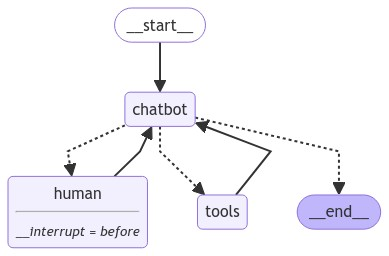

In [25]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [26]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (call_Ef6wM9Kkc98jvgKQWoo3BATr)
 Call ID: call_Ef6wM9Kkc98jvgKQWoo3BATr
  Args:
    request: I need expert guidance on building an AI agent, including best practices, tools, and frameworks to use. I'm also looking for advice on the design and implementation process.


In [27]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

In [29]:
ai_message = snapshot.values["messages"][-1]

In [31]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

In [32]:
tool_message = create_response(human_response, ai_message)

In [33]:
tool_message

ToolMessage(content="We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.", tool_call_id='call_Ef6wM9Kkc98jvgKQWoo3BATr')

In [34]:
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef683b0-51a5-637c-8002-25714ff4f2e2'}}

In [35]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', id='9e0e4e04-adef-4dcc-b1e6-97c362c29136'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Ef6wM9Kkc98jvgKQWoo3BATr', 'function': {'arguments': '{"request":"I need expert guidance on building an AI agent, including best practices, tools, and frameworks to use. I\'m also looking for advice on the design and implementation process."}', 'name': 'RequestAssistance'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 160, 'total_tokens': 207}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f33667828e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-668b1c05-2b80-4313-85fd-49582681dfe4-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': "I need expert guidance on building an AI agent, including best practices, tools, and frameworks to use. I'm 

In [36]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

I've requested expert guidance for you, and they recommend using LangGraph to build your AI agent. It's considered more reliable and extensible compared to simpler autonomous agents. If you have any specific questions about using LangGraph or need further assistance, feel free to ask!


## 7 - Time Travel